# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
!pip install afinn
from afinn import Afinn
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
import nltk
from nltk import word_tokenize 
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]
        

def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())
    

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2), 
                             max_df = 0.5, min_df = 5, lowercase=True, stop_words=tokenized_stop_words)
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['exclam_count'] = movie_data['review'].str.count("\!")
    movie_data['q_count'] = movie_data['review'].str.count("\?")
    movie_data['q_star'] = movie_data['review'].str.count("\*")
    movie_data['q_hash'] = movie_data['review'].str.count("\#")
    
    # uppercase letter count
    import string
    movie_data['upper'] = [sum(1 for letter in c if letter.isupper()) for c in movie_data['review']]
    
    #afinn sentiment dictionary score from modifierd dictionary of only negative sentiment words
   
    afn = Afinn()
    
    movie_data['afinn_score'] = [afn.score(c) for c in movie_data['review']]

    X_quant_features = movie_data[['word_count', 'punc_count','exclam_count',
                                   'q_count','upper','q_star','q_hash','afinn_score']]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

[nltk_data] Downloading package punkt to /Users/asadakhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/asadakhan/Documents/Study/ml_22/week05/moviereviews_train.tsv', my_random_seed=65)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         433          20             1        2     59       0       0   
1     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [6]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_error")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 5046, 'TN': 4973, 'FP': 5124, 'FN': 4857, 'Accuracy': 0.50095, 'Precision': 0.49616519174041296, 'Recall': 0.5095425628597394, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [7]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=50)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 8094, 'TN': 9959, 'FP': 138, 'FN': 1809, 'Accuracy': 0.90265, 'Precision': 0.9832361516034985, 'Recall': 0.8173280823992729, 'desc': 'svm_train'}


### MODEL: logistic regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',alpha=30, early_stopping=True)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 8787, 'TN': 9847, 'FP': 250, 'FN': 1116, 'Accuracy': 0.9317, 'Precision': 0.9723359521965254, 'Recall': 0.8873068767040291, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

ValueError: Negative values in data passed to MultinomialNB (input X)

### MODEL: Perceptron

In [10]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 9903, 'TN': 10097, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=4, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 9789, 'TN': 10017, 'FP': 80, 'FN': 114, 'Accuracy': 0.9903, 'Precision': 0.9918938088965448, 'Recall': 0.9884883368676158, 'desc': 'rdg_train'}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### MODEL: Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=500, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9903, 'Neg': 10097, 'TP': 9903, 'TN': 10097, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

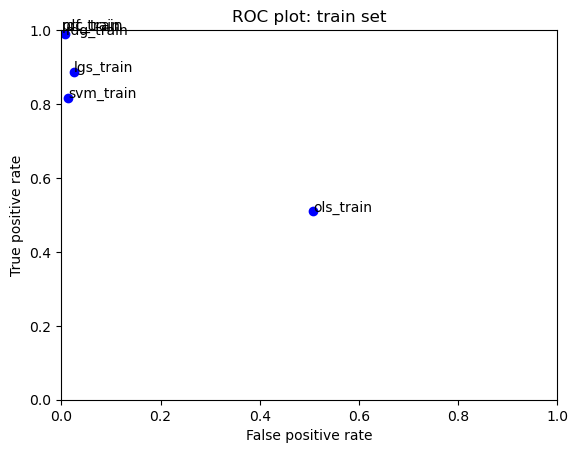

In [13]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
#         nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [14]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [36]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
7
I think that, deep down in the darkest, slimiest part of their heart, everyone likes Jerry Springer just a little bit. While his show is undeniably offensive and stupid, it also gives us a chance to see that, relatively speaking, most of us have it real good. When you look at the trailer park livin', dollar whiskey drinkin', incest lovin' people on the Springer show, it makes even your worst day seem like a walk in the park. Jerry is performing a public service, and we should be grateful. He ditched a political career to host the show, just for us.<br /><br />What we should not be grateful for in any way is the piece of garbage movie \Ringmaster\". \"Ringmaster\" shows what life is like for people who wind up being guests on the show, or so they would like us to think. The movie follows the pre-requisite Springer story line: Love triangles. One triangle involves Connie, her daughter Angel, and her husband Rusty. The other involves Starletta, Vonda, and De

7563
I am a huge Jane Austen fan and I ordered the movie from Amazon.UK just so I could see it without waiting forever for it to come to the U.S. I really should have saved my money. What is with Anne running after Wentworth? The whole point of Anne Elliot's character is that she was quiet and refined. She is not impulsive and vulgar. And Mary, was she suffering from a stroke or something? Her speech wasn't normal, nor was her walking normal. There was no chemistry between the two main characters which made their whole \romance\" completely unbelievable. In the final scene they even have Sally Hawkins wearing the same dress Amanda Root wore during the letter scene. The same clothes do not make it the same movie. In my opinion they didn't watch the 1995 version, which even though it had it's flaws, it did stay pretty close to the book. The book, I don't even think they read it. This is kind of like a Cliff's Notes movie of Persuasion. Hit on all the high points without explaining anythi

16214
Basic slasher movie premise, 3 young ladies wreck their car and end up staying with a creepy family. YAWN.<br /><br />Watching 36 minutes of a premonition of OJ's car chase with a white sedan instead of a bronco. YAWN.<br /><br />Old lady with hot and cold dementia controlling her daughter... YAWN<br /><br />23 minutes of watching the actors eat - YAWN Trying to identify what the heck they are eating ... OK there might be a drinking game here ... nope - YAWN <br /><br />Complimentary shower scenes ... OK got my interest for a couple of seconds.<br /><br />Completely random and uninspired killings ... YAWN <br /><br />The ending ... dude! that psycho is deranged - why couldn't the rest of the movie be like the last 5 minutes... unfortunately that is it - My advice - fast forward to the last five minutes and watch that and then put something good in the player - for me I am going back to sleep.
* * * * * * * * * 
16281
I cannot believe that I wasted five hours of my life on this ru

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 1370, 'TN': 1169, 'FP': 1234, 'FN': 1227, 'Accuracy': 0.5078, 'Precision': 0.5261136712749616, 'Recall': 0.5275317674239507, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 1790, 'TN': 2286, 'FP': 117, 'FN': 807, 'Accuracy': 0.8152, 'Precision': 0.9386470896696382, 'Recall': 0.6892568348093955, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 2041, 'TN': 2219, 'FP': 184, 'FN': 556, 'Accuracy': 0.852, 'Precision': 0.9173033707865168, 'Recall': 0.7859068155564113, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 2183, 'TN': 2031, 'FP': 372, 'FN': 414, 'Accuracy': 0.8428, 'Precision': 0.8544031311154598, 'Recall': 0.8405852907200616, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 2310, 'TN': 2102, 'FP': 301, 'FN': 287, 'Accuracy': 0.8824, 'Precision': 0.8847184986595175, 'Recall': 0.889487870619946, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2597, 'Neg': 2403, 'TP': 2150, 'TN': 2031, 'FP': 372, 'FN': 447, 'Accuracy': 0.8362, 'Precision': 0.852498017446471, 'Recall': 0.8278783211397767, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

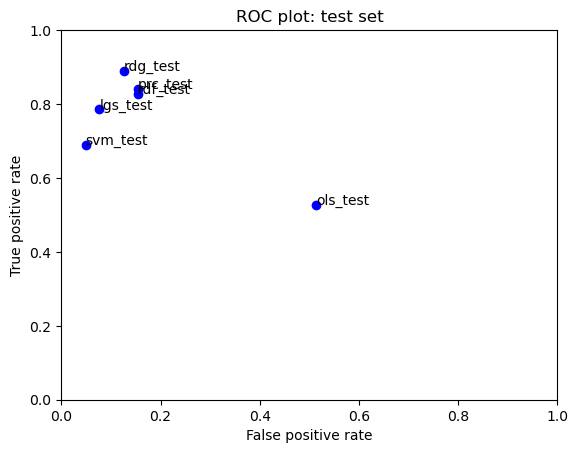

In [22]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
#         nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/asadakhan/Documents/Study/ml_22/week05/moviereviews_test.tsv', my_random_seed=65, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         131           5             0        0      7       0       0   
1         169          15             1        0     15       0       0   
2         176          18             0        0     25       0  

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [40]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = prc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.46208


In [41]:
raw_data.head()

,id,review,word_count,punc_count,exclam_count,q_count,q_star,q_hash,upper,afinn_score
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0,0,0,7,0.0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,0,0,0,15,-4.0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0,0,0,25,24.0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0,0,0,10,-5.0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0,0,0,17,13.0


In [42]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [43]:
my_submission.shape

(25000, 2)

In [44]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/asadakhan/Documents/Study/ml_22/week05/moviereviews_submissionprc.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation